# Bias Detection with **MSD**

**Maximum Subgroup Discrepancy (MSD)** measures how far two distributions differ inside their worst-case protected subgroup.

* Two datasets are **close** iff every subgroup defined by the
  protected attributes behaves similarly.  
* MSD keeps that worst-case guarantee **and** needs only **O(# protected features)**
  samples (linear) instead of the exponential sample sizes required by
  classical distances such as Total Variation or Wasserstein.

**Why this matters**: MSD uncovers hidden *intersectional* bias that
  marginal metrics miss **and** returns the exact logical rule describing the
  most disadvantaged group.


## Demo dataset  `01_data.csv`

| Column   | Type & values                                                 | Role            |
|----------|--------------------------------------------------------------|-----------------|
| `Race`   | categorical {Green, Blue, Purple}                            | protected       |
| `Age`    | categorical {0-18, 18-30, 30-45, 45-60, 60+}                 | protected       |
| `Target` | binary {0, 1} (e.g. loan approval)                           | outcome tested  |

The toy data are crafted so that global **demographic parity** holds  
(each race × age bucket has the same mean `Target`) **but young Blue people are
severely under-served**.  
MSD should discover exactly that subgroup.

<img src="../images/motivation_MSD.png" width="600">

In [1]:
dataset_path = "../data/01_data.csv"

target = "Target"
protected_list = ["Race", "Age"]

In [2]:
from humancompatible.detect import most_biased_subgroup_csv, evaluate_biased_subgroup_csv

rule = most_biased_subgroup_csv(
    csv_path=dataset_path,
    target_col=target,
    protected_list=protected_list,
    method="MSD",
)

msd_val = evaluate_biased_subgroup_csv(
    csv_path=dataset_path,
    target_col=target,
    protected_list=protected_list,
    method="MSD",
    method_kwargs={"rule": rule},
)


[INFO] Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
[INFO] RUN!
[INFO] MIP  has 264 rows; 39 cols; 700 nonzeros; 9 integer variables (9 binary)
[INFO] Coefficient ranges:
[INFO]   Matrix [3e-02, 2e+00]
[INFO]   Cost   [1e+00, 1e+00]
[INFO]   Bound  [1e+00, 1e+00]
[INFO]   RHS    [1e+00, 2e+00]
[INFO] Presolving model
[INFO] 205 rows, 39 cols, 613 nonzeros  0s
[INFO] 205 rows, 39 cols, 613 nonzeros  0s
[INFO] 
[INFO] Solving MIP model with:
[INFO]    205 rows
[INFO]    39 cols (9 binary, 0 integer, 0 implied int., 30 continuous, 0 domain fixed)
[INFO]    613 nonzeros
[INFO] 
[INFO] Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
[INFO]      H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
[INFO]      I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
[INFO]      z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Tri

In [3]:
print(f"MSD value: {msd_val:.3f}")
print(f"Rule: {rule}")

MSD value: 0.111
Rule: [(0, Bin(<humancompatible.detect.data_handler.features.Categorical.Categorical object at 0x000001CBA5804590>, <Operation.EQ: '='>, 'Blue')), (1, Bin(<humancompatible.detect.data_handler.features.Categorical.Categorical object at 0x000001CBA58147D0>, <Operation.EQ: '='>, '0-18'))]


## Interpreting the rule

`rule` is a list of pairs of original feature indices (columns) and `Bin` objects, that describe the condition applied to a given feature value. The bins can be easily printed: 

In [4]:
print("The group is: " + " AND ".join(str(r) for _, r in rule))

The group is: Race = Blue AND Age = 0-18


We can also use the `Bin` objects to simply evaluate samples using the rule.

In [5]:
import numpy as np

samples = np.array([["Blue", "0-18"], ["Green", "0-18"], ["Blue", "40-60"]])

in_group = np.ones(samples.shape[0], dtype=bool)
for i, r in rule:
    in_group &= r.evaluate(samples[:,i])
in_group

array([ True, False, False])

## Conclusion

**MSD score**  
  The computed MSD of **0.111…** tells us that the subgroup  
  **`Race = Blue AND Age = 0–18`**  
  appears **11.1 percentage points more often** among the negative outcomes than among the positive outcomes.

**What does this mean**  
  In this toy dataset, "Blue young persons" are the most disproportionally-served subgroup, as evident from the image.

# Bias Detection with $l_\infty$

With the **Subsampled** $l_\infty$ **norm**, we can quickly check the bias for a particular subgroup.

**Why this matters**: This comes in handy for cases in which a predetermined bias threshold has to be checked to comply with legal standards.

## Demo dataset  `01_data+gender.csv`

| Column   | Type & values                                                 | Role            |
|----------|--------------------------------------------------------------|-----------------|
| `Gender` | categorical {M,F}                                            | protected       |
| `Race`   | categorical {Green, Blue, Purple}                            | protected       |
| `Age`    | categorical {0-18, 18-30, 30-45, 45-60, 60+}                 | protected       |
| `Target` | binary {0, 1} (e.g. loan approval)                           | outcome tested  |

The new attribute *Gender* has been added in a way that mantains the previous **demographic parity**

In [6]:
dataset_path = "../data/01_data+gender.csv"

target = "Target"
protected_list = ["Race", "Age", "Gender"]

Internally, $l_\infty$ compares two normalised histograms:

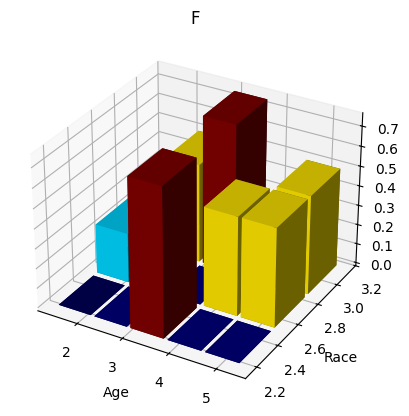

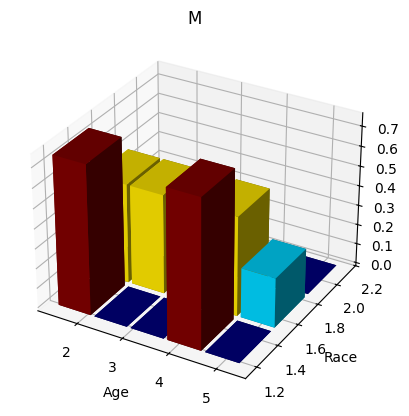

In [7]:
from supports.linf_utils import plot_3D_histogram, load_histograms

load_histograms(csv_path=dataset_path,
    target_col=target,
    protected_list=protected_list,
    method_kwargs={'feature_involved': 'Gender', 'subgroup_to_check': 'F'})

Above, we can compare visually the occurrences of the positive outcome in the different subgroups from the *Age* and *Race* fields, for the two possible values of the *Gender* attribute.

To run the method, we input the group (`subgroup_to_check`) and the corresponding feature (`feature_involved`) that we want to check, along with the desired bias level (`delta`) to be checked.

In [8]:
from humancompatible.detect import evaluate_biased_subgroup_csv

msd_val = evaluate_biased_subgroup_csv(
    csv_path=dataset_path,
    target_col=target,
    protected_list=protected_list,
    method="l_inf",
    method_kwargs={'delta': .125, 'feature_involved': 'Gender', 'subgroup_to_check': 'F'}
)

[INFO] The most impacted subgroup bias > 0.125
